# Inleiding

In aparte notebook tutorial van Fast F1 gedaan. Beetje verkennen en thuisraken. In dit notebook gaan we echt aan de slag met *Data Understanding*. De centrale vraag daarbij is: hoe kunnen we de data vinden die nodig is om de businessvraag te beantwoorden?

Wat we in ieder geval moeten kunnen:

1. Alle races in een bepaalde periode vinden
2. In een race alle coureurs vinden die de race hebben uitgereden
3. De laps van een coureur vinden
4. De gemiddelde snelheid van een lap bepalen
5. Race met hoogste gemiddelde snelheid vinden


# Stap 1: Welke races in een periode?



Alle packages die we in dit notebook nodig hebben:

In [77]:
import fastf1
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from statistics import mean, stdev

Welke races werden er gereden in een gegeven periode?

In [2]:
NUM_OF_YEARS = 5

current_year = dt.date.today().year
first_year = current_year - NUM_OF_YEARS
years = list(range(first_year, current_year+1)) 

print(f'Years in scope: {years=}')

print('Race calendars of the years in scope:')
for year in years:
    print(fastf1.get_event_schedule(year))

req         WARNING 	

DEFAULT CACHE ENABLED!
	Cache directory: C:\Users\jan-willem.lankhaar\AppData\Local\Temp\fastf1.
	Size: 2.13 GB


Years in scope: years=[2018, 2019, 2020, 2021, 2022, 2023]
Race calendars of the years in scope:
    RoundNumber               Country           Location  \
0             1             Australia          Melbourne   
1             2               Bahrain             Sakhir   
2             3                 China           Shanghai   
3             4            Azerbaijan               Baku   
4             5                 Spain          Barcelona   
5             6                Monaco        Monte Carlo   
6             7                Canada           Montréal   
7             8                France       Le Castellet   
8             9               Austria          Spielberg   
9            10         Great Britain        Silverstone   
10           11               Germany         Hockenheim   
11           12               Hungary           Budapest   
12           13               Belgium  Spa-Francorchamps   
13           14                 Italy              Monza   
14 

Beetje onoverzichtelijk. Interessante kolom is `EventDate`. 

#### Complicatie: standaard en `pandas` `datetime`s
`EventDate` is geen Python standaard `datetime`-object, maar een `pandas` `Timestamp` (in de code aangeduid met `pd.Timestamp` want door `import pandas as pd` in de eerste cel, is alles van `pandas` herkenbaar aan het voorvoegsel `pd.`). 

Berekening van periode in scope moet dus iets anders.

In [3]:
latest = pd.Timestamp(dt.datetime.now())
earliest = latest - pd.DateOffset(years=NUM_OF_YEARS)
print(f'{earliest=}, {latest=}')

events_raw = pd.concat((fastf1.get_event_schedule(y, include_testing=False) for y in years), ignore_index=True)
races = events_raw[(events_raw['EventDate'] >= earliest) & (events_raw['EventDate'] <= latest)]

for _, e in races.iterrows():
    print(f"{e['EventDate']}")

earliest=Timestamp('2018-11-23 10:17:46.646224'), latest=Timestamp('2023-11-23 10:17:46.646224')
2018-11-25 00:00:00
2019-03-17 00:00:00
2019-03-31 00:00:00
2019-04-14 00:00:00
2019-04-28 00:00:00
2019-05-12 00:00:00
2019-05-26 00:00:00
2019-06-09 00:00:00
2019-06-23 00:00:00
2019-06-30 00:00:00
2019-07-14 00:00:00
2019-07-28 00:00:00
2019-08-04 00:00:00
2019-09-01 00:00:00
2019-09-08 00:00:00
2019-09-22 00:00:00
2019-09-29 00:00:00
2019-10-13 00:00:00
2019-10-27 00:00:00
2019-11-03 00:00:00
2019-11-17 00:00:00
2019-12-01 00:00:00
2020-07-05 00:00:00
2020-07-12 00:00:00
2020-07-19 00:00:00
2020-08-02 00:00:00
2020-08-09 00:00:00
2020-08-16 00:00:00
2020-08-30 00:00:00
2020-09-06 00:00:00
2020-09-13 00:00:00
2020-09-27 00:00:00
2020-10-11 00:00:00
2020-10-25 00:00:00
2020-11-01 00:00:00
2020-11-15 00:00:00
2020-11-29 00:00:00
2020-12-06 00:00:00
2020-12-13 00:00:00
2021-03-28 00:00:00
2021-04-18 00:00:00
2021-05-02 00:00:00
2021-05-09 00:00:00
2021-05-23 00:00:00
2021-06-06 00:00:00
202

#### Complicatie: verkeerde racesessie

`get_event_schedule()` geeft als resultaat een verzameling `Events` terug. Je zou dan rechtstreeks de methode `Event.get_race()` moeten kunnen gebruiken om de racesessie op te halen. Echter, dit lijkt niet goed te gaan (het lijkt erop dat je steeds de allereerste race van het `EventSchedule` terugkrijgt). We nemen in plaats daarvan een kleine omweg. We gebruiken alleen de `EventDate` en `OfficialEventName` om de juiste race te identificeren en halen met de algemene functie `fastf1.get_session()` de race zelf op.

Wat beschrijvende zaken:

In [4]:
print(f'Number of GP\'s: {len(races)}')
print(f'First race: {races.iloc[0]["OfficialEventName"]} on {races.iloc[0]["EventDate"]}')
print(f'Last race: {races.iloc[-1]["OfficialEventName"]} on {races.iloc[-1]["EventDate"]}')

q = races.iloc[-1]
s = fastf1.get_session(year=q['EventDate'].year, gp=q['OfficialEventName'], identifier='Race')
s.load()

print(s.results)

for _,row in s.results.iterrows():
    print(f"{row['ClassifiedPosition']}: {row['FullName']}")


core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.1.5]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Number of GP's: 104
First race: FORMULA 1 2018 ETIHAD AIRWAYS ABU DHABI GRAND PRIX on 2018-11-25 00:00:00
Last race: FORMULA 1 HEINEKEN SILVER LAS VEGAS GRAND PRIX 2023 on 2023-11-18 00:00:00


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '31', '18', '55', '44', '63', '14', '81', '10', '23', '20', '3', '24', '2', '77', '22', '27', '4']


   DriverNumber BroadcastName Abbreviation         DriverId         TeamName  \
1             1  M VERSTAPPEN          VER   max_verstappen  Red Bull Racing   
16           16     C LECLERC          LEC          leclerc          Ferrari   
11           11       S PEREZ          PER            perez  Red Bull Racing   
31           31        E OCON          OCO             ocon           Alpine   
18           18      L STROLL          STR           stroll     Aston Martin   
55           55       C SAINZ          SAI            sainz          Ferrari   
44           44    L HAMILTON          HAM         hamilton         Mercedes   
63           63     G RUSSELL          RUS          russell         Mercedes   
14           14      F ALONSO          ALO           alonso     Aston Martin   
81           81     O PIASTRI          PIA          piastri          McLaren   
10           10       P GASLY          GAS            gasly           Alpine   
23           23       A ALBON          A

# Stap 2: Coureurs die race hebben uitgereden

Uit de output van de `s.results` en de documentatie kan worden opgemaakt, dat coureurs die de race hebben uitgereden de status `Finished` krijgen in de `Status`-kolom. Zoek de coureurs die gefinisht zijn en hun laps.

In [7]:
finished_drivers = [r['DriverNumber'] for _, r in s.results.iterrows() if r['Status'] == 'Finished']

# Stap 3: Laps van een coureur vinden

De lap-data van een coureur in eenvoudig te vinden omdat dit ook op het `session`-object beschikbaar is:

In [8]:
laps_of_interest = s.laps[s.laps['DriverNumber'].isin(finished_drivers)]

# Stap 4: De gemiddelde snelheid van een lap vinden

De snelheidsmetingen van een lap kunnen worden opgehaald met de methode `Lap.get_car_data()`. We kunnen dan een tijd (binnen de lap) en de snelheid krijgen:

In [22]:
first_lap = laps_of_interest.iloc[0]
car_data = first_lap.get_car_data()
for _, row in car_data[['Time', 'Speed']].iterrows():
    print(f'Time in lap: {row[0]}, Speed: {row[1]} km/h')

Time in lap: 0 days 00:00:00.134000, Speed: 0 km/h
Time in lap: 0 days 00:00:00.374000, Speed: 0 km/h
Time in lap: 0 days 00:00:00.654000, Speed: 4 km/h
Time in lap: 0 days 00:00:00.974000, Speed: 17 km/h
Time in lap: 0 days 00:00:01.374000, Speed: 30 km/h
Time in lap: 0 days 00:00:01.694000, Speed: 36 km/h
Time in lap: 0 days 00:00:01.934000, Speed: 42 km/h
Time in lap: 0 days 00:00:02.094000, Speed: 52 km/h
Time in lap: 0 days 00:00:02.374000, Speed: 62 km/h
Time in lap: 0 days 00:00:02.614000, Speed: 66 km/h
Time in lap: 0 days 00:00:02.854000, Speed: 76 km/h
Time in lap: 0 days 00:00:03.054000, Speed: 80 km/h
Time in lap: 0 days 00:00:03.214000, Speed: 91 km/h
Time in lap: 0 days 00:00:03.414000, Speed: 99 km/h
Time in lap: 0 days 00:00:03.614000, Speed: 107 km/h
Time in lap: 0 days 00:00:03.974000, Speed: 115 km/h
Time in lap: 0 days 00:00:04.294000, Speed: 137 km/h
Time in lap: 0 days 00:00:04.534000, Speed: 146 km/h
Time in lap: 0 days 00:00:04.694000, Speed: 155 km/h
Time in la

## Zijn de snelheidsmetingen op vaste tijden? 

Wordt de snelheid regelmatig gemeten of varieert de tijd tussen twee metingen? Laten we naar het verschil tussen twee tijdmetingen (`delta_t`) kijken:

Text(0.5, 1.0, 'Time between speed measurements\nAverage = 0.27 $\\pm$ 0.10 s')

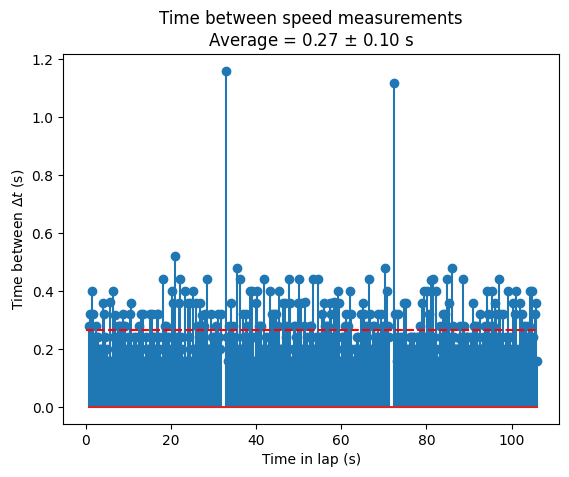

In [53]:
inlap_time = car_data['Time'].dt.total_seconds()

# diff() gives the difference between to consecutive values.
delta_t = car_data['Time'].diff().dt.total_seconds()    # Convert timedelta to seconds
delta_t.pop(0)  # Remove first element because it is not a duration (by definition)

avg_time = mean(delta_t)
std_time = stdev(delta_t)
plt.stem(inlap_time[2:], delta_t[1:])
plt.xlabel('Time in lap (s)')
plt.ylabel('Time between $\\Delta t$ (s)')
plt.plot([0, inlap_time.to_list()[-1]], [avg_time, avg_time], 'r--')
plt.title(f'Time between speed measurements\nAverage = {avg_time:.2f} $\\pm$ {std_time:.2f} s')


Conclusie: Uitgaande van deze ene lap van deze ene coureur (!), is het tijdsverschil tussen twee metingen in 66% van de gevallen tussen 0,17 en 0,37 s. Dit is voor de businessvraag prima.

Omdat de snelheden van een lap op regelmatige tijden worden gemeten, is het bepalen van een betrouwbaar gemiddelde heel eenvoudig:

In [75]:
avg_speeds = []
for _, lap in laps_of_interest.iterrows():
    car_data = lap.get_car_data()
    lap_speed =  car_data['Speed'].to_list()
    avg_speeds.append(mean(lap_speed))
    print(f'Average of lap: {avg_speeds[-1]:.1f} km/h')
    
hr = "-"*100    # Create a horizontal line of dashes
print(f'\n\n{hr}\n\tAverage of race: {mean(avg_speeds):.2f} km/h\n{hr}')

Average of lap: 205.4 km/h
Average of lap: 166.0 km/h
Average of lap: 204.2 km/h
Average of lap: 118.7 km/h
Average of lap: 132.8 km/h
Average of lap: 138.9 km/h
Average of lap: 219.5 km/h
Average of lap: 220.8 km/h
Average of lap: 219.7 km/h
Average of lap: 222.3 km/h
Average of lap: 223.3 km/h
Average of lap: 222.8 km/h
Average of lap: 225.1 km/h
Average of lap: 221.7 km/h
Average of lap: 220.1 km/h
Average of lap: 210.2 km/h
Average of lap: 183.2 km/h
Average of lap: 224.5 km/h
Average of lap: 226.6 km/h
Average of lap: 223.2 km/h
Average of lap: 227.1 km/h
Average of lap: 225.4 km/h
Average of lap: 225.4 km/h
Average of lap: 224.3 km/h
Average of lap: 225.8 km/h
Average of lap: 193.5 km/h
Average of lap: 127.6 km/h
Average of lap: 134.8 km/h
Average of lap: 217.3 km/h
Average of lap: 228.0 km/h
Average of lap: 226.1 km/h
Average of lap: 227.8 km/h
Average of lap: 228.4 km/h
Average of lap: 227.4 km/h
Average of lap: 230.9 km/h
Average of lap: 231.0 km/h
Average of lap: 229.1 km/h
A

# Stap 5: Race met hoogste gemiddelde snelheid

Om de snelste race te vinden, moeten we alleen nog bovenstaande bij elkaar brengen. Omdat de data van meerdere races laden veel tijd kost, faken we even wat data. We gaan ervan uit dat de racegemiddelden zijn opgeslagen in een Python `dictionary`. We kunnen slim gebruikmaken van de functie `max()` om de sleutel (key) van de maximale waarde in de dictionary te vinden:

In [76]:
fake_race_avg_speeds = {
    'Fake Race 1' : 145.456,
    'Fake Race 2' : 239.24,
    'Fake Race 3' : 211.98,
    'Fake Race 4' : 195.34
} 

fastest_race = max(fake_race_avg_speeds, key=fake_race_avg_speeds.get) #type:ignore
print(f'\n\n{hr}\n\tThe fastest race was: {fastest_race} with an average speed of {fake_race_avg_speeds[fastest_race]} km/h\n{hr}')



----------------------------------------------------------------------------------------------------
	The fastest race was: Fake Race 2 with an average speed of 239.24 km/h
----------------------------------------------------------------------------------------------------


# Samenvatting

We hebben de businessvraag vertaald naar concrete en specifieke *data mining goals*.

We begrijpen nu in grote lijnen hoe we:

1. Data kunnen ophalen met de `fastf1` API
2. Races in een gegeven periode kunnen selecteren
3. Kunnen nagaan welke coureurs een race hebben uitgereden
4. Laps van specifieke coureurs in een race kunnen selecteren
5. De gemiddelde snelheid van een lap kunnen bepalen
6. Hoe we de totale gemiddelde snelheid van een race kunnen bepalen
7. Hoe we de race met de hoogste totale gemiddelde snelheid kunnen vinden

Wat we NIET (of nauwelijks) hebben gedaan:

- Een gedetailleerde beschrijving van de data geven
- Nagaan of de datakwaliteit voldoende is voor het beantwoorden van de businessvraag

Als we voor het gemak even aannemen dat de datakwaliteit geen probleem is, hebben we alle ingrediënten voor data preparation. Hoe we dat doen, wordt toegelicht in het notebook **Data Preparation**.
